In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import glob
import statistics
import pandas as pd
%matplotlib inline

In [2]:
## basic read in

In [3]:
def max_acc_point(acc_list):
    acc_point = np.argmax(acc_list)
    return acc_point

In [4]:
def min_loss_point(loss_list):
    loss_point = np.argmin(loss_list)
    return loss_point

In [5]:
def index_less_than(mylist,myvalue,value2):
    for i in range(len(mylist)):
        if mylist[i]<myvalue:
            if mylist[i]>0.78:
                return len(mylist)-1
            else:
                return i
    return len(mylist)-1

In [6]:
def es_point(acc_list,p): # p means steps after the max index
    max_num = 0
    count = 0
    for i in range(len(acc_list)):
        if acc_list[i]>max_num:
            max_num = acc_list[i]
            count = 0
        count = count+1
        if count>p:
            return i-1
    return int(len(acc_list)-1)

In [7]:
def windowed(s,half_window): # s is a list
    s_mean=[]
    s_var=[]
    window_size = half_window*2 + 1
    for i in range(len(s)-window_size+1):
        k = i + half_window 
        s_sub=s[k-half_window:k+half_window+1]
        sub_mean=sum(s_sub)/len(s_sub)
        s_mean.append(sub_mean)
        sub_var=statistics.variance(s_sub)
        s_var.append(sub_var)
    return s_mean,s_var

In [8]:
def read_acc_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['acc'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean
def read_loss_mean(files,i,speed=1):
    fileset = pd.concat( [pd.read_csv(f,header=None,sep=' ',names=['loss','acc'])['loss'] for f in files], axis=1)
    normalset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==False], axis=1)
    normalset_mean = normalset.mean(axis=1).dropna()
    if speed==1:
        return normalset_mean   
    delayset = pd.concat( [fileset.iloc[:,i] for i in range(len(fileset.columns)) if fileset.iloc[:,i].isnull().any()==True], axis=1)
    delayset_mean = delayset.mean(axis=1).dropna()
    return normalset_mean,delayset_mean

In [9]:
## how to plot

In [10]:
def plot_line(i,k,basedir,result,lab,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    s1_epo = [i+1 for i in s1[0][:p]]
    ax[i].plot(s1_epo,s1[2][:p], label=lab[k]+addon)

In [11]:
def plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon=''):
    s1=np.load(os.path.join(basedir,result[k]))
    p=1000
    
    (s_mean,s_varience)=windowed(s1[2][:p],half_window)

    s_epo=[i+half_window+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label=lab[k]+addon,color = line_color) # can also plot s_varience if want
    
    (s_loss,_)=windowed(s1[1][:p],half_window)
    
    index_min_loss = min_loss_point(s_loss)
    ax[i].plot(index_min_loss+half_window+1,s_mean[index_min_loss],dot_color)
    
    
#     # for bad node only
#     index_min_loss = min_loss_point(s_loss)
#     index_min_acc = min_loss_point(s_mean[index_min_loss:])+index_min_loss
#     min_acc = s_mean[index_min_acc]
#     index_less_than_nb = index_less_than(s_mean[index_min_loss:],min_acc+0.025,1)+index_min_loss
#     acc_drop = s_mean[index_less_than_nb]
#     ax[i].scatter(index_less_than_nb,acc_drop,c='k')
    

#     index_max=np.argmax(s_mean)
#     ax[i].plot(index_max,s_mean[index_max],dot_color)


In [12]:
def plot_file_acc(i,k,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        set_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(set_plt,normalset_mean, label=linelab+'_t')
#         print('only usual')
        
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)
        
        normal_plt = [i+1 for i in range(len(normalset_mean))]
        ax[i].plot(normal_plt,normalset_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        delay_plt = [i+1 for i in range(len(new_delay_set))]
        ax[i].plot(delay_plt,new_delay_set, label=linelab+'_delay')

In [13]:
def plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed=1,filename='self_EVAL.txt'):
    files = glob.glob(basedir +'/'+ node_dir[k]+ '/worker_nodes/*/'+filename)
    linelab = lab[k]
    if speed==1:
        normalset_mean = read_acc_mean(files,i,speed)
        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_t')
    else:
        normalset_mean,delayset_mean = read_acc_mean(files,i,speed)

        (s_mean,s_varience)=windowed(normalset_mean,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_usual')
        
        new_delay_set = [val for val in delayset_mean for _ in range(speed)]
        (s_mean,s_varience)=windowed(new_delay_set,half_window)
        s_epo=[i+half_window+1 for i in range(len(s_mean))]
        ax[i].plot(s_epo,s_mean, label=linelab+'_delay')


## Data Dispersion

In [14]:
basedir=os.path.join('DataDispersion')
# os.listdir(basedir)

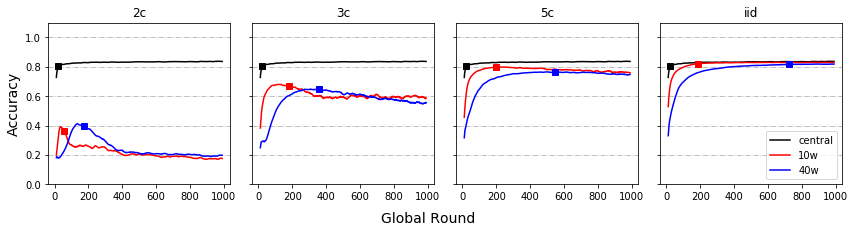

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(12, 3))
fig.text(0.5, -0.05, 'Global Round', ha='center',fontsize=14)
# fig.suptitle('40k',y=1.05,fontsize=16)


title_list = ['2c','3c','5c','iid']

# in order: dly8-30/12/3, dly20, dly32
result=[
    '2c.10w.40000.loc1.earlystop1000.20200521-163612.npy',
    '2c.40w.40000.loc1.earlystop1000.20200522-110021.npy',
    
    '3c.10w.40000.loc1.earlystop1000.20200523-042344.npy',
    '3c.40w.40000.loc1.earlystop1000.20200524-022211.npy',
    
    '5c.10w.40000.loc1.earlystop1000.20200521-171047.npy',
    '5c.40w.40000.loc1.earlystop1000.20200522-110113.npy',
    
    'iid.10w.40000.loc1.earlystop1000.20200521-172951.npy',
    'iid.40w.40000.loc1.earlystop1000.20200522-105548.npy',
]

lab=[
    '10w','40w',
    '10w','40w',
    '10w','40w',
    '10w','40w',
]

node_dir = [
    'loc2c1s','dd2',
    'loc3c1s','dd3',
    'loc5c1s','dd5',
    'lociid1s','ddiid',
]


line_color_list = [ 'r','b', 'g',  'm', 'c','y']
dot_color_list = [ 'rs',  'bs','gs', 'ms', 'cs','ys']



half_window=10
for i in range(4):

#     s1=np.load('40000_central.batch100.es500.npy')
#     s_epo=[i+1 for i in range(1000)]
#     ax[i].plot(s_epo,s1[2][:1000], label='central',color = 'k') 
    
    s1=np.load('40000_central.batch100.es500.npy')
    (s_mean,s_varience)=windowed(s1[2][:1000],half_window)
    (s_loss,_)=windowed(s1[1][:1000],half_window)
    s_epo=[i+half_window+1 for i in range(len(s_mean))]
    ax[i].plot(s_epo,s_mean, label='central',color = 'k') 
    index_min_loss = min_loss_point(s_loss)
    ax[i].plot(index_min_loss,s_mean[index_min_loss],'ks')
    
    for j in [0,1]:
        
        k = i*2+j
        speed = 1     

        line_color = line_color_list[j]
        dot_color = dot_color_list[j]
        
#         plot_line(i,k,basedir,result,lab,addon='')
#         plot_file_acc(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon='')
#         plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        


    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[i].set_title(title_list[i])

    
# ax[0].set_ylim([0.15, 0.45])
# ax[1].set_ylim([0.55, 0.85])
# ax[2].set_ylim([0.55, 0.85])  
# ax[3].set_ylim([0.55, 0.85])  
    
    
ax[0].set_ylabel('Accuracy',fontsize=14)
ax[-1].legend() 
plt.tight_layout()
plt.show()

## Bad Node

In [16]:
basedir=os.path.join('BadNode')
# os.listdir(basedir)

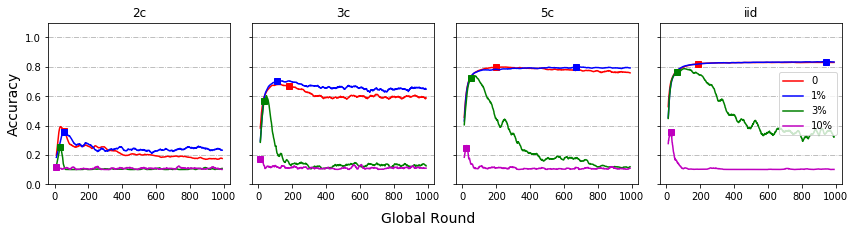

In [17]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(12, 3))
fig.text(0.5, -0.05, 'Global Round', ha='center',fontsize=14)
# fig.suptitle('40k',y=1.05,fontsize=16)

title_list = ['2c','3c','5c','iid']

result=[
    '2c.10w.40000.loc1.earlystop1000.20200521-163612.npy',
    '2c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-150153.npy',
    '2c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055725.npy',
    '2c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-152141.npy',
    
    '3c.10w.40000.loc1.earlystop1000.20200523-042344.npy',
    '3c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200523-043427.npy',
    '3c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-054717.npy',
    '3c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200523-043024.npy',
    
    '5c.10w.40000.loc1.earlystop1000.20200521-171047.npy',
    '5c.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-152400.npy',
    '5c.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055914.npy',
    '5c.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-165039.npy',
    
    'iid.10w.40000.loc1.earlystop1000.20200521-172951.npy',
    'iid.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-185542.npy',
    'iid.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055848.npy',
    'iid.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-152331.npy',
]

lab=[
    '0','1%','3%','10%',    
    '0','1%','3%','10%',    
    '0','1%','3%','10%',    
    '0','1%','3%','10%',    

]


node_dir = [
    'loc2c1s','bad2c400','bad2c1200','bad2c4000',
    'loc3c1s','bad3c400','bad3c1200','bad3c4000',
    'loc5c1s','bad5c400','bad5c1200','bad5c4000',
    'lociid1s','badiid400','badiid1200','badiid4000',
]


line_color_list = [ 'r','b', 'g',  'm', 'c','y']
dot_color_list = [ 'rs',  'bs','gs', 'ms', 'cs','ys']

half_window=10
for i in range(4):
    
    for j in [0,1,2,3]:
        k = i*4+j
        speed = 1     
        
        line_color = line_color_list[j]
        dot_color = dot_color_list[j]
        
#         plot_line(i,k,basedir,result,lab,addon='')
#         plot_file_acc(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon='')
#         plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        

    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[i].set_title(title_list[i])
#     ax[i].legend() 
    
ax[0].set_ylabel('Accuracy',fontsize=14)
ax[-1].legend() 
plt.tight_layout()
plt.show()

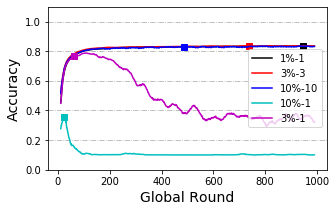

In [18]:
s1=np.load(os.path.join(basedir,'iid.10w.40000.plus1bad_each400.loc1.earlystop1000.20200521-185542.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '1%-1',color='k') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ks')

s1=np.load(os.path.join(basedir,'newbad1200-3.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '3%-3',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join(basedir,'newbad4000-10.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '10%-10',color='b') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'bs')

s1=np.load(os.path.join(basedir,'iid.10w.40000.plus1bad_each4000.loc1.earlystop1000.20200521-152331.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '10%-1',color='c') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')

s1=np.load(os.path.join(basedir,'iid.10w.40000.plus1bad_each1200.loc1.earlystop1000.20200523-055848.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = '3%-1',color='m') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'ms')

plt.gcf().set_size_inches(5, 3)

plt.ylabel('Accuracy',fontsize=14) 
plt.ylim([0, 1.1])    
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

## Share Data

In [24]:
basedir=os.path.join('ShareData')
# os.listdir(basedir)

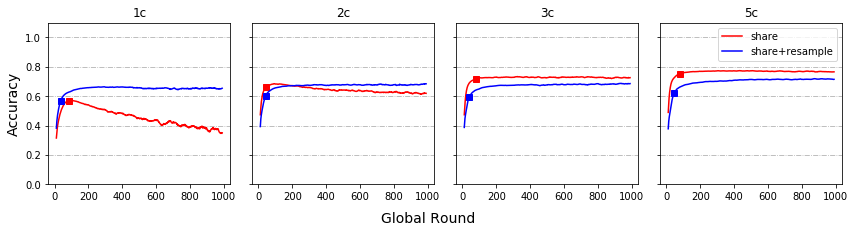

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(12, 3))
fig.text(0.5, -0.05, 'Global Round', ha='center',fontsize=14)
# fig.suptitle('40k',y=1.05,fontsize=16)

title_list = ['1c','2c','3c','5c','iid']

result=[
    '1c.10w.40000.share1000.loc1.earlystop1000.20200521-194921.npy',
    '1c.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-031407.npy',
    '2c.10w.40000.share1000.loc1.earlystop1000.20200521-195746.npy',
    '2c.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-025937.npy',
    '3c.10w.40000.share1000.loc1.earlystop1000.20200523-053810.npy',
    '3c.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-003350.npy',
    '5c.10w.40000.share1000.loc1.earlystop1000.20200521-194613.npy',
    '5c.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-040734.npy',
    'iid.10w.40000.share1000.loc1.earlystop1000.20200521-195217.npy',
    'iid.10w.40000.share1000.loc1.earlystop1000.20200521-195217.npy',
]

lab=[
    'share','share+resample',
    'share','share+resample',
    'share','share+resample',
    'share','share+resample',
    'share','share+resample',
]


node_dir = ['sd1n','sd1','sd2n','sd2','sd3n','sd3','sd5n','sd5','sdiid','sdiid']


line_color_list = [ 'r','b', 'g',  'm', 'c','y']
dot_color_list = [ 'rs',  'bs','gs', 'ms', 'cs','ys']

half_window=10

for i in range(4):
    
    for j in [0,1]:
        k = i*2+j
        speed = 1     
        
        line_color = line_color_list[j]
        dot_color = dot_color_list[j]
        
#         plot_line(i,k,basedir,result,lab,addon='')
#         plot_file_acc(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon='')
#         plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        

    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[i].set_title(title_list[i])
#     ax[i].legend() 
    
ax[0].set_ylabel('Accuracy',fontsize=14)
ax[-1].legend() 
plt.tight_layout()
plt.show()

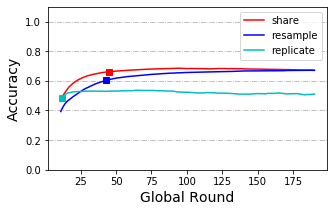

In [36]:
s1=np.load(os.path.join(basedir,'2c.10w.40000.share1000.loc1.earlystop1000.20200521-195746.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'share',color='r') 
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join(basedir,'2c.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-025937.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'resample',color='b') 
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'bs')

s1=np.load(os.path.join(basedir,'2c.10w.40000.share1000.replicate.npy'))
(s_mean,s_varience)=windowed(s1[2][:200],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'replicate',color='c')
(s_loss,_)=windowed(s1[1][:200],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'cs')


plt.gcf().set_size_inches(5, 3)

plt.ylabel('Accuracy',fontsize=14) 
# plt.ylim([0.7, 0.8])  
plt.ylim([0, 1.1])   
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

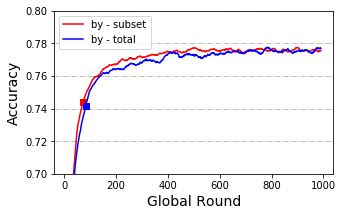

In [21]:
s1=np.load(os.path.join(basedir,'currentsd.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-033124.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'by - subset',color='r') 
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'rs')

s1=np.load(os.path.join(basedir,'newsd.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-054734.npy'))
(s_mean,s_varience)=windowed(s1[2][:1000],half_window)
s_epo=[i+half_window+1 for i in range(len(s_mean))]
plt.plot(s_epo,s_mean,label = 'by - total',color='b')
(s_loss,_)=windowed(s1[1][:1000],half_window)
index_min_loss = min_loss_point(s_loss)
plt.plot(index_min_loss+half_window+1,s_mean[index_min_loss],'bs')

# s1=np.load(os.path.join(basedir,'currentsd.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-033124.npy'))
# s_epo=[i+1 for i in range(1000)]
# plt.plot(s_epo,s1[2][:1000],label = 'current',color='r') 

# s1=np.load(os.path.join(basedir,'newsd.10w.40000.share1000_lociid.loc1.earlystop1000.20200523-054734.npy'))
# s_epo=[i+1 for i in range(1000)]
# plt.plot(s_epo,s1[2][:1000],label = 'new',color='b') 



plt.gcf().set_size_inches(5, 3)

plt.ylabel('Accuracy',fontsize=14) 
plt.ylim([0.7, 0.8])  
# plt.ylim([0, 1.1])   
plt.xlabel('Global Round',fontsize=14)      
plt.grid(axis="y",ls='-.')
plt.legend()

## Late update in some node

In [22]:
basedir=os.path.join('DelayUpdate')
# os.listdir(basedir)

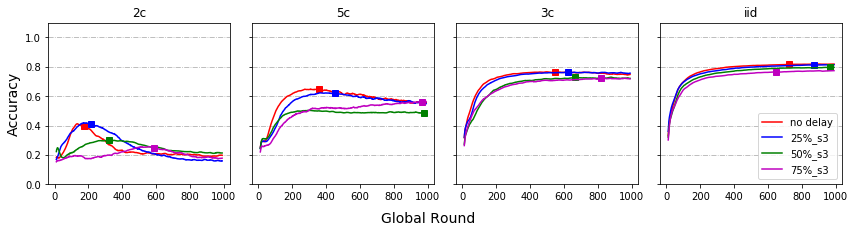

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=4, sharex=True, sharey=True, figsize=(12, 3))
fig.text(0.5, -0.05, 'Global Round', ha='center',fontsize=14)
# fig.suptitle('40k',y=1.05,fontsize=16)


title_list = ['2c','5c','3c','iid']

# in order: dly8-30/12/3, dly20, dly32
result=[
    '2c.40w.40000.loc1.earlystop1000.20200522-110021.npy',
    '2c.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-081302.npy',
    '2c.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-010225.npy',
    '2c.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-182838.npy',    
    '2c.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-051203.npy',    
    '2c.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-050704.npy',
    
    '3c.40w.40000.loc1.earlystop1000.20200524-022211.npy',  
    '3c.40w.40000.dly10.speed3.loc1.earlystop1000.20200523-200048.npy',
    '3c.40w.40000.dly20.speed3.loc1.earlystop1000.20200523-132646.npy',
    '3c.40w.40000.dly30.speed3.loc1.earlystop1000.20200523-065723.npy',    
    '3c.40w.40000.dly10.speed15.loc1.earlystop1000.20200523-173144.npy',    
    '3c.40w.40000.dly10.speed30.loc1.earlystop1000.20200523-163044.npy',

    
    
    '5c.40w.40000.loc1.earlystop1000.20200522-110113.npy',
    '5c.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-074328.npy',
    '5c.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-010608.npy',
    '5c.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-184510.npy',  
    '5c.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-043519.npy',    
    '5c.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-053311.npy',


    'iid.40w.40000.loc1.earlystop1000.20200522-105548.npy',
    'iid.40w.40000.dly10.speed3.loc1.earlystop1000.20200522-072117.npy',
    'iid.40w.40000.dly20.speed3.loc1.earlystop1000.20200522-012812.npy',
    'iid.40w.40000.dly30.speed3.loc1.earlystop1000.20200521-185705.npy',   
    'iid.40w.40000.dly10.speed15.loc1.earlystop1000.20200522-053936.npy',    
    'iid.40w.40000.dly10.speed30.loc1.earlystop1000.20200522-073107.npy',  
]

lab=[
    'no delay','25%_s3','50%_s3','75%_s3', '25%_s15','25%_s30', 
    'no delay','25%_s3','50%_s3','75%_s3', '25%_s15','25%_s30', 
    'no delay','25%_s3','50%_s3','75%_s3', '25%_s15','25%_s30',     
    'no delay','25%_s3','50%_s3','75%_s3', '25%_s15','25%_s30', 
]


node_dir = [
    'dd2', 'du2c1','du2c2','du2c3','du2c4','du2c5',
    'dd3', 'du3c1','du3c2','du3c3','du3c4','du3c5',
    'dd5', 'du5c1','du5c2','du5c3','du5c4','du5c5',
    'ddiid', 'duiid1','duiid2','duiid3','duiid4','duiid5'
]

speed_list = [1,3,3,3,15,30,1,3,3,3,15,30,1,3,3,3,15,30,1,3,3,3,15,30]

line_color_list = [ 'r','b', 'g',  'm', 'c','y']
dot_color_list = [ 'rs',  'bs','gs', 'ms', 'cs','ys']

half_window=10

for i in range(4):
    
    for j in [0,1,2,3]:
#     for j in [0,1,4,5]:
        
        k = i*6+j
        
        speed = speed_list[k]
#         print(speed)
        
        line_color = line_color_list[j]
        dot_color = dot_color_list[j]
        
#         plot_line(i,k,basedir,result,lab,addon='')
#         plot_file_acc(i,k,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        plot_window_acc(i,k,half_window,basedir,result,lab,line_color,dot_color,addon='')
#         plot_file_window_acc(i,k,half_window,basedir,node_dir,lab,speed,filename='self_EVAL.txt')
        

    ax[i].set_ylim([0, 1.1])
    ax[i].grid(axis="y",ls='-.')
    ax[i].set_title(title_list[i])
    
# ax[0].set_ylim([0.1, 0.1+0.35])
# ax[1].set_ylim([0.68, 0.78])
# ax[2].set_ylim([0.75, 0.85])
# ax[3].set_ylim([0.75, 0.85])


    
ax[0].set_ylabel('Accuracy',fontsize=14)
ax[-1].legend() 
plt.tight_layout()
plt.show()